In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization


from ase.build import bulk
from ase.io.trajectory import Trajectory
from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

/home/vr371/.local/lib/python3.8/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


#### Purpose of this code
After generating the data, we utilized supervised machine learning models, with the Ewald matrix (or Coulomb matrix for periodic systems) as our X variable and $\rho_{0}$ as our y variable.

In [2]:
path_pp='/home/vr371/PP/ofpp/EAC/upf/blps/'
file1='si.lda.upf'
PP_list = {'Si': path_pp+file1}

All the data will be compare with KS calculations, so we load the KS total energy of the system

#### Learning using Kernel Ridge regression
In the following cells we apply ML implementing Kernel ridge regression to learn rho0 parameter
$$
X = Ewal\ sum \ matrix
$$
$$
y = \rho_{0}
$$
Define the interface to obtain the $\rho_{0}$ for all the Si phases

In [3]:
from sklearn.model_selection import train_test_split 
from sklearn.kernel_ridge import KernelRidge #as modelKR
from sklearn.linear_model import Ridge #as modelR
from sklearn.linear_model import Lasso
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, SOAP
from sklearn.tree import DecisionTreeRegressor

In [26]:
def main():
    print('Allowed phases: Si_Btin, Si_fcc, Si_bcc, Si_8cd, and Si_7cd')
    print('Models: DecisionTree, and KernelRide')
    print('Available descriptors: Ewal_matrix, and Sine_matrix')
    Phase = input('Please type in the Phase of silicon you want to study:')
    model = input('Please type The regression model you want to use:')
    descriptor = input('Please type The descriptor you want to use:')
    real_rho0, pred_rho0, vol = ML_regression(Phase, model, descriptor) 
    ks_energy, real_energy, pred_energy, volume_30 = get_energy(Phase, real_rho0, pred_rho0)
    
    fig, axs = plt.subplots(1,2, figsize=(10,3))
    im0 = axs[0].plot(np.asarray(volume_30)*0.529177**3/4,np.asarray(real_rho0),'b*--')
    im1 = axs[0].plot(np.asarray(vol)*0.529177**3/4,np.asarray(pred_rho0),'r*--')
    im2 = axs[1].plot(np.asarray(volume_30)*0.529177**3/4,(np.asarray(real_energy))*27.211407/4,'b*--')
    im3 = axs[1].plot(np.asarray(vol)*0.529177**3/4,(np.asarray(pred_energy))*27.211407/4,'r*--')
    im4 = axs[1].plot(np.asarray(volume_30)*0.529177**3/4,(np.asarray(ks_energy))*27.211407/8,'g*--')
    fig.suptitle(f'Phase: {str(Phase)}, Descriptor: {str(descriptor)}, Model: {str(model)}')
#     axs[0].set_title(str(model))
#     axs[1].set_title(str(Phase))
    axs[0].set_xlabel('Volume ($\AA^{3}$)')
    axs[0].set_ylabel('$\u03C1_{0}$')
    axs[1].set_xlabel('Volume ($\AA^{3}$)')
    axs[1].set_ylabel('Energy (eV/atom)')
    axs[0].legend(['Real', 'Predicted'])
    axs[1].legend(['OF', 'Predicted', 'KS'])

In [27]:
def ML_regression(Phase, model, descriptor):
    dictionary = {
        'Si_Btin': {'structure': 'diamond', 'pp': 'si.lda.recpot'}, 
        'Si_fcc': {'structure': 'fcc', 'lattice': '3.405'},
        'Si_bcc': {'structure': 'bcc', 'lattice': '3.09'},
        'Si_8cd': {'structure': 'diamond', 'lattice': '5.43'},
        'Si_7cd': {'structure': 'diamond', 'lattice': '5.43'},
    }
    if model == 'KernelRidge':
        model = KernelRidge(alpha=0.001, kernel='rbf', kernel_params={'gamma': 0.1})
    if model == 'DecisionTree':
        model = DecisionTreeRegressor(max_depth=25)
    
    rho0_Btin = np.load("/home/vr371/cWT-KEDF/Phases/DATA/Si_Btin/DATA2/rho0.npy") #
    rho0_fcc = np.load("/home/vr371/cWT-KEDF/Phases/DATA/Si_fcc/DATA2/rho0.npy") #
    rho0_bcc = np.load("/home/vr371/cWT-KEDF/Phases/DATA/Si_bcc/DATA2/rho0.npy") #
    rho0_8cd = np.load("/home/vr371/cWT-KEDF/Phases/DATA/Si_8cd/DATA2/rho0.npy")
    rho0_7cd = np.load("/home/vr371/cWT-KEDF/Phases/DATA/Si_7cd/DATA2/rho0.npy")
    rho0 = np.hstack((rho0_Btin, rho0_fcc, rho0_bcc, rho0_8cd.reshape(30), rho0_7cd.reshape(30)))
    
    if descriptor=='Ewal_matrix':
        Ewal_matrices = np.load('/home/vr371/cWT-KEDF/Phases/DATA/Ewal_matrices.npy')  
        esm_Btin = np.asarray(Ewal_matrices)[:30,0]
        esm_fcc = np.asarray(Ewal_matrices)[:30,1]
        esm_bcc = np.asarray(Ewal_matrices)[:30,2]
        esm_8cd = np.asarray(Ewal_matrices)[:30,3]
        esm_7cd = np.asarray(Ewal_matrices)[:30,4]
        Matrix = np.vstack((esm_Btin, esm_fcc, esm_bcc, esm_8cd, esm_7cd))
    if descriptor=='Sine_matrix':
        Sine_matrices = np.load('/home/vr371/cWT-KEDF/Phases/DATA/Sine_matrices.npy')
        sine_Btin = np.asarray(Sine_matrices)[:30,0]
        sine_fcc = np.asarray(Sine_matrices)[:30,1]
        sine_bcc = np.asarray(Sine_matrices)[:30,2]
        sine_8cd = np.asarray(Sine_matrices)[:30,3]
        sine_7cd = np.asarray(Sine_matrices)[:30,4]
        Matrix = np.vstack((sine_Btin, sine_fcc, sine_bcc, sine_8cd, sine_7cd))

    X = Matrix.reshape(150,8,8)
    y = np.asarray(rho0)
    
    rh0 = []
    for j, r0 in enumerate(y):
            rho0_matrix = np.zeros((len(X[1])*len(X[1])))
            rho0_matrix[0] = r0
            rh0.append(rho0_matrix)
    X = X.reshape(-1, len(X[1])*len(X[1]))
    y = np.asarray(rh0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    
    r = np.linspace(0.8, 1.4, 30)
    VOLUME = []
    pred_rho0 =[]
    for i, d in enumerate(r):
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))   
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_cell(cell * d, scale_atoms=True)
        vol=ions.get_volume()
        if descriptor=='Ewal_matrix':
            esm = EwaldSumMatrix(n_atoms_max=8)
            X_pol = esm.create(ions)
        if descriptor=='Sine_matrix':
            sine = SineMatrix(n_atoms_max=8)
            X_pol = sine.create(ions)
        y_pred = model.predict(X_pol.reshape(-1, len(X_pol)))
        pred_rho0.append(y_pred[0,0])
        VOLUME.append(vol)
    
    if Phase == 'Si_Btin':
        real_rho0 = rho0[0:30]
    if Phase == 'Si_fcc':
        real_rho0 = rho0[30:60]
    if Phase == 'Si_bcc':
        real_rho0 = rho0[60:90]
    if Phase == 'Si_8cd':
        real_rho0 = rho0[90:120]
    if Phase == 'Si_7cd':
        real_rho0 = rho0[120:150]
    return np.asarray(real_rho0), np.asarray(pred_rho0), np.asarray(VOLUME)

In [28]:
def get_energy(Phase, real_rho0, pred_rho0):
    dictionary = {
        'Si_Btin': {'structure': 'diamond', 'pp': 'si.lda.recpot'}, 
        'Si_fcc': {'structure': 'fcc', 'lattice': '3.405'},
        'Si_bcc': {'structure': 'bcc', 'lattice': '3.09'},
        'Si_8cd': {'structure': 'diamond', 'lattice': '5.43'},
        'Si_7cd': {'structure': 'diamond', 'lattice': '5.43'},
    }
    KS_TE = []
    for i in np.arange(0,30,1):
        with open('/home/vr371/cWT-KEDF/Phases/DATA/'+ str(Phase)+ '/DATA2/Si'+str(i)+'.out') as D:
            k = [match for match in D if "Total energy" in match]
        KS_te = str(k).split()[6]
        KS_TE.append(float(KS_te))

    VOLUME_30 = []
    l = np.linspace(0.8, 1.4, 30)
    for i, d in enumerate(l):
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_cell(cell * d, scale_atoms=True)
        vol=ions.get_volume()
        VOLUME_30.append(vol)
    
    r = np.linspace(0.8, 1.4, 30)
    real_rho0 = np.asarray(real_rho0)
    real_energy = []
    XC = Functional(type='XC',name='LDA')
    HARTREE = Functional(type='HARTREE')
    for i, d in enumerate(r):
        real_KE = Functional(type='KEDF',name='WT', rho0=real_rho0[i])
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_charges(4)
        ions.set_cell(cell * l[i], scale_atoms=True)
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        realevaluator = TotalFunctional(KE=real_KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        optimization_options = {'econv' : 1e-5*ions.nat}
        optreal = Optimization(EnergyEvaluator=realevaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        realrho = optreal.optimize_rho(guess_rho=rho_ini)
        realenergy = realevaluator.Energy(rho=realrho, ions=ions)
        real_energy.append(realenergy)

    l = np.linspace(0.8, 1.4, 30)
    pred_rho0 = np.asarray(pred_rho0) 
    pred_energy = []
    VOLUME = []
    for i, d in enumerate(l):
        pred_KE = Functional(type='KEDF',name='WT', rho0=pred_rho0[i])
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_charges(4)
        ions.set_cell(cell * l[i], scale_atoms=True)
        nr = ecut2nr(ecut=25, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        predevaluator = TotalFunctional(KE=pred_KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        optimization_options = {'econv' : 1e-5*ions.nat}
        optpred = Optimization(EnergyEvaluator=predevaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        predrho = optpred.optimize_rho(guess_rho=rho_ini)
        predenergy = predevaluator.Energy(rho=predrho, ions=ions)
        pred_energy.append(predenergy)
    return np.asarray(KS_TE), np.asarray(real_energy), np.asarray(pred_energy), np.asarray(VOLUME_30)

By increasing the number of predicted $\rho_{0}$ values, the equation of state plot exhibits a smoother behavior.

Please type in the Phase of silicon you want to study:Si_Btin
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Sine_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.810500545993E+00      9.810501E+00    4.864010E+00    1       1       6.125689E-03    
1       8.809912917731E+00      -1.000588E+00   2.772556E-01    4       2       2.512097E-02    
2       8.792713431881E+00      -1.719949E-02   2.038247E-02    4       1       3.949285E-02    
3       8.790314062934E+00      -2.399369E-03   1.270956E-03    6       1       7.870388E-02    
4       8.790243845906E+00      -7.021703E-05   8.532844E-05    4       1       1.028781E-01    
5       8.790235305479E+00      -8.540427E-06   8.447197E-06    5       1       1.285260E-01    
6       8.790234550647E+00      -7.548324E-07   6.290358E-07    6       1       

1       4.089728473524E+00      -8.669794E-01   1.663567E-01    7       2       3.738308E-02    
2       4.079169701114E+00      -1.055877E-02   1.121724E-02    4       1       5.318141E-02    
3       4.078135634081E+00      -1.034067E-03   1.024812E-03    5       1       7.195973E-02    
4       4.078059149265E+00      -7.648482E-05   8.348147E-05    6       1       9.360528E-02    
5       4.078052829748E+00      -6.319516E-06   6.576531E-06    5       1       1.119382E-01    
6       4.078051400486E+00      -1.429262E-06   1.404883E-07    8       1       1.385102E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3951893483007489
Chemical potential (eV)  : 10.753648883237988
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.556389029367E+00      4.556389E+00    2.801719E+00    1       1       6.860733E-03    
1       3.665264659346E+00  

6       1.208951674279E+00      -5.088039E-07   3.349396E-07    6       1       3.101263E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18244894354575333
Chemical potential (eV)  : 4.964688158840801
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.273920846138E+00      2.273921E+00    2.332492E+00    1       1       8.932829E-03    
1       9.469752300889E-01      -1.326946E+00   3.534140E-01    12      2       6.887269E-02    
2       9.211249044141E-01      -2.585033E-02   3.040482E-02    4       1       9.042263E-02    
3       9.164014631945E-01      -4.723441E-03   1.265675E-03    8       1       1.273134E-01    
4       9.162655820597E-01      -1.358811E-04   8.744806E-05    5       1       1.525030E-01    
5       9.162544858750E-01      -1.109618E-05   5.930583E-06    7       1       1.841695E-01    
6       9.162537460280E-01  

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05057260943574636
Chemical potential (eV)  : 1.3761506663060892
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.949408264520E-01      9.949408E-01    2.174474E+00    1       1       1.140189E-02    
1       -9.278805003164E-01     -1.922821E+00   1.468261E+00    14      2       1.038661E-01    
2       -1.063981523642E+00     -1.361010E-01   7.312458E-02    9       1       1.600125E-01    
3       -1.070424325441E+00     -6.442802E-03   4.320895E-03    5       1       1.945372E-01    
4       -1.070937715918E+00     -5.133905E-04   2.222567E-04    7       1       2.395074E-01    
5       -1.070972671023E+00     -3.495510E-05   1.132684E-05    9       1       2.941351E-01    
6       -1.070973854754E+00     -1.183732E-06   6.731201E-07    6       1       3.340108E-01    
#### Density Optimization C

Chemical potential (a.u.): 0.6535499193804645
Chemical potential (eV)  : 17.78399744554221
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       7.565454710104E+00      7.565455E+00    3.841782E+00    1       1       6.101370E-03    
1       6.700683915635E+00      -8.647708E-01   2.406586E-01    5       2       2.799487E-02    
2       6.684175738764E+00      -1.650818E-02   2.348236E-02    4       1       4.321599E-02    
3       6.681472325798E+00      -2.703413E-03   1.916225E-03    6       1       6.341720E-02    
4       6.681324935496E+00      -1.473903E-04   1.299172E-04    5       1       8.071923E-02    
5       6.681308740589E+00      -1.619491E-05   9.101713E-06    7       1       1.031911E-01    
6       6.681308426461E+00      -3.141289E-07   6.493853E-07    3       1       1.151948E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.

2       2.870294297471E+00      -7.217333E-03   8.940969E-03    4       1       6.948638E-02    
3       2.869434640695E+00      -8.596568E-04   7.027563E-04    6       1       9.621978E-02    
4       2.869334766160E+00      -9.987454E-05   5.212869E-05    8       1       1.296020E-01    
5       2.869330280478E+00      -4.485681E-06   4.387521E-06    5       1       1.522582E-01    
6       2.869329609372E+00      -6.711062E-07   2.037475E-07    7       1       1.818151E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3028060737715604
Chemical potential (eV)  : 8.239772177698265
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.532745555269E+00      3.532746E+00    2.551229E+00    1       1       7.636070E-03    
1       2.516018156189E+00      -1.016727E+00   1.566581E-01    9       2       4.993367E-02    
2       2.507854087292E+00   

7       3.638932597288E-01      -1.665181E-07   1.088556E-07    6       1       2.771056E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.12546348293448908
Chemical potential (eV)  : 3.4140349403315637
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.711022380616E+00      1.711022E+00    2.259481E+00    1       1       8.676052E-03    
1       1.523009848586E-01      -1.558721E+00   7.517960E-01    12      2       7.239366E-02    
2       1.113513411602E-01      -4.094964E-02   4.345583E-02    4       1       9.642410E-02    
3       1.030746565161E-01      -8.276685E-03   3.537294E-03    8       1       1.369517E-01    
4       1.024925345921E-01      -5.821219E-04   3.051599E-04    7       1       1.723459E-01    
5       1.024582627549E-01      -3.427184E-05   2.426368E-05    5       1       1.997585E-01    
6       1.024542065170E-01 

7       -1.485383288616E+00     -3.725511E-06   7.265453E-07    10      1       5.921936E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.01570742110075511
Chemical potential (eV)  : 0.4274206582363087
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.649305061096E-01      6.649305E-01    2.131721E+00    1       1       1.108289E-02    
1       -2.692594881913E-01     -9.341900E-01   1.004281E+01    18      2       1.710052E-01    
2       -1.658587871265E+00     -1.389328E+00   5.021817E-01    9       2       2.625635E-01    
3       -1.680382558862E+00     -2.179469E-02   4.484477E-02    3       1       2.973359E-01    
4       -1.683594815234E+00     -3.212256E-03   3.822249E-03    5       1       3.477275E-01    
5       -1.684622704639E+00     -1.027889E-03   2.810464E-04    10      1       4.388525E-01    
6       -1.684652097062E+00

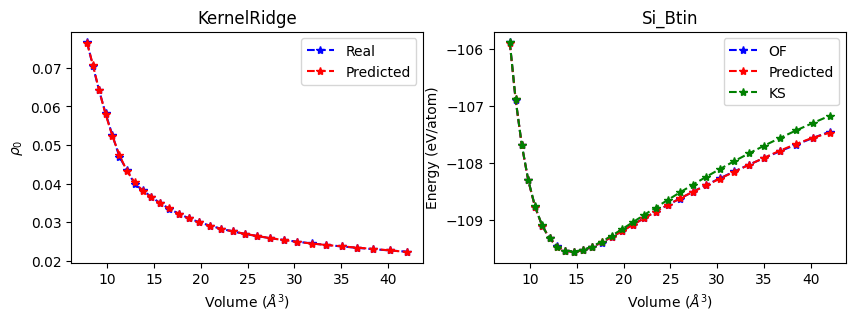

In [12]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_Btin
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Ewal_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.810500545993E+00      9.810501E+00    4.864010E+00    1       1       6.109476E-03    
1       8.809912917731E+00      -1.000588E+00   2.772556E-01    4       2       2.396750E-02    
2       8.792713431881E+00      -1.719949E-02   2.038247E-02    4       1       3.775787E-02    
3       8.790314062934E+00      -2.399369E-03   1.270956E-03    6       1       5.572796E-02    
4       8.790243845906E+00      -7.021703E-05   8.532844E-05    4       1       6.913280E-02    
5       8.790235305479E+00      -8.540427E-06   8.447197E-06    5       1       8.479786E-02    
6       8.790234550647E+00      -7.548324E-07   6.290358E-07    6       1       

1       4.089728473524E+00      -8.669794E-01   1.663567E-01    7       2       3.533363E-02    
2       4.079169701114E+00      -1.055877E-02   1.121724E-02    4       1       5.138826E-02    
3       4.078135634081E+00      -1.034067E-03   1.024812E-03    5       1       7.025290E-02    
4       4.078059149265E+00      -7.648482E-05   8.348147E-05    6       1       9.178782E-02    
5       4.078052829748E+00      -6.319516E-06   6.576531E-06    5       1       1.101949E-01    
6       4.078051400486E+00      -1.429262E-06   1.404883E-07    8       1       1.367285E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3951893483007489
Chemical potential (eV)  : 10.753648883237988
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.556389029367E+00      4.556389E+00    2.801719E+00    1       1       7.003069E-03    
1       3.665264659346E+00  

6       1.208951674279E+00      -5.088039E-07   3.349396E-07    6       1       2.122324E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18244894354575333
Chemical potential (eV)  : 4.964688158840801
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.273920846138E+00      2.273921E+00    2.332492E+00    1       1       8.301258E-03    
1       9.469752300889E-01      -1.326946E+00   3.534140E-01    12      2       6.635904E-02    
2       9.211249044141E-01      -2.585033E-02   3.040482E-02    4       1       8.867860E-02    
3       9.164014631945E-01      -4.723441E-03   1.265675E-03    8       1       1.258276E-01    
4       9.162655820597E-01      -1.358811E-04   8.744806E-05    5       1       1.506529E-01    
5       9.162544858750E-01      -1.109618E-05   5.930583E-06    7       1       1.832583E-01    
6       9.162537460280E-01  

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05057260943574636
Chemical potential (eV)  : 1.3761506663060892
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.949408264520E-01      9.949408E-01    2.174474E+00    1       1       1.020885E-02    
1       -9.278805003164E-01     -1.922821E+00   1.468261E+00    14      2       9.848714E-02    
2       -1.063981523642E+00     -1.361010E-01   7.312458E-02    9       1       1.533835E-01    
3       -1.070424325441E+00     -6.442802E-03   4.320895E-03    5       1       1.875212E-01    
4       -1.070937715918E+00     -5.133905E-04   2.222567E-04    7       1       2.320893E-01    
5       -1.070972671023E+00     -3.495510E-05   1.132684E-05    9       1       2.869122E-01    
6       -1.070973854754E+00     -1.183732E-06   6.731201E-07    6       1       3.257334E-01    
#### Density Optimization C

Chemical potential (a.u.): 0.6634710219708484
Chemical potential (eV)  : 18.053964372156788
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       7.565454710104E+00      7.565455E+00    3.841782E+00    1       1       5.903244E-03    
1       6.701100434639E+00      -8.643543E-01   2.399233E-01    5       2       2.759290E-02    
2       6.684663710285E+00      -1.643672E-02   2.332333E-02    4       1       4.268837E-02    
3       6.681982859680E+00      -2.680851E-03   1.892779E-03    6       1       6.251454E-02    
4       6.681837093146E+00      -1.457665E-04   1.283064E-04    5       1       7.998109E-02    
5       6.681820986102E+00      -1.610704E-05   4.417161E-06    7       1       1.025453E-01    
6       6.681820800194E+00      -1.859077E-07   4.135120E-07    3       1       1.142797E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0

2       2.869584555427E+00      -7.238298E-03   8.984946E-03    4       1       6.948185E-02    
3       2.868719530750E+00      -8.650247E-04   7.083556E-04    6       1       9.610677E-02    
4       2.868618885370E+00      -1.006454E-04   5.255687E-05    8       1       1.292050E-01    
5       2.868614354615E+00      -4.530755E-06   4.446249E-06    5       1       1.514754E-01    
6       2.868613674626E+00      -6.799887E-07   2.073207E-07    7       1       1.804583E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.30274785595046394
Chemical potential (eV)  : 8.238187990246072
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.532745555269E+00      3.532746E+00    2.551229E+00    1       1       7.673264E-03    
1       2.515796711798E+00      -1.016949E+00   1.567428E-01    9       2       5.071378E-02    
2       2.507626824787E+00  

6       3.635813286217E-01      -4.144625E-06   2.731850E-06    7       1       2.344432E-01    
7       3.635809395375E-01      -3.890842E-07   2.290615E-07    6       1       2.659693E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.12544985017585025
Chemical potential (eV)  : 3.413663974109062
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.711022380616E+00      1.711022E+00    2.259481E+00    1       1       8.734465E-03    
1       1.524723274474E-01      -1.558550E+00   7.515609E-01    12      2       7.252264E-02    
2       1.115368721540E-01      -4.093546E-02   4.343613E-02    4       1       9.659743E-02    
3       1.032648010968E-01      -8.272071E-03   3.532872E-03    8       1       1.371250E-01    
4       1.026836589817E-01      -5.811421E-04   3.049367E-04    7       1       1.727989E-01    
5       1.026494127546E-01  

6       -1.485709664831E+00     -2.917465E-05   1.684481E-05    7       1       5.042861E-01    
7       -1.485713402709E+00     -3.737878E-06   7.315265E-07    10      1       5.942016E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.015691296234830763
Chemical potential (eV)  : 0.4269818783269177
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.649305061096E-01      6.649305E-01    2.131721E+00    1       1       1.111960E-02    
1       -2.691758031100E-01     -9.341063E-01   1.004172E+01    18      2       1.667657E-01    
2       -1.658003606940E+00     -1.388828E+00   5.022981E-01    9       2       2.584164E-01    
3       -1.679783326486E+00     -2.177972E-02   4.489584E-02    3       1       2.929680E-01    
4       -1.682997323904E+00     -3.213997E-03   3.817436E-03    5       1       3.429482E-01    
5       -1.684024479232E+0

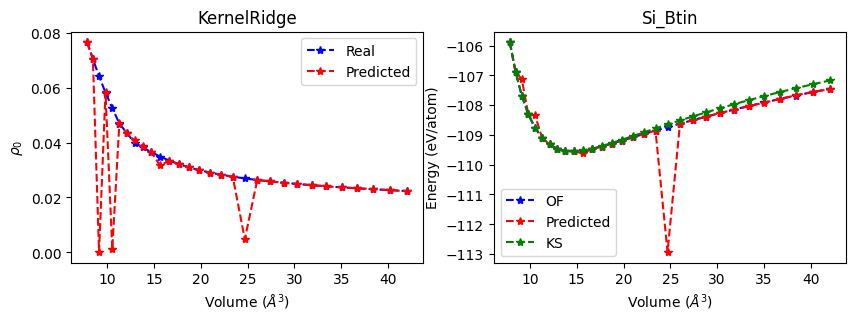

In [13]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_bcc
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Sine_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.121982952391E+00      5.121983E+00    2.529854E+00    1       1       5.660057E-03    
1       4.670227091437E+00      -4.517559E-01   1.177824E-01    3       1       1.748466E-02    
2       4.657286760293E+00      -1.294033E-02   2.874532E-03    5       1       3.006911E-02    
3       4.657145540485E+00      -1.412198E-04   1.160652E-04    3       1       3.898263E-02    
4       4.657132887006E+00      -1.265348E-05   5.688647E-06    5       1       5.130076E-02    
5       4.657132349374E+00      -5.376321E-07   3.113244E-07    4       1       6.178284E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.81836153090

2       2.291080237930E+00      -1.169330E-02   6.702460E-03    6       1       3.440547E-02    
3       2.290551498341E+00      -5.287396E-04   6.609304E-04    4       1       4.588366E-02    
4       2.290476354563E+00      -7.514378E-05   4.071206E-05    6       1       6.160951E-02    
5       2.290473910370E+00      -2.444192E-06   3.451194E-06    3       1       7.108927E-02    
6       2.290473564450E+00      -3.459204E-07   2.085310E-07    5       1       8.493590E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.4301623152047616
Chemical potential (eV)  : 11.705311695274721
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.397220644184E+00      2.397221E+00    1.329625E+00    1       1       4.597902E-03    
1       2.085880810041E+00      -3.113398E-01   9.925410E-02    5       1       2.129245E-02    
2       2.072406907980E+00  

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.20337471421179737
Chemical potential (eV)  : 5.53410732795906
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.212375318915E+00      1.212375E+00    1.088331E+00    1       1       6.989479E-03    
1       6.770652270284E-01      -5.353101E-01   1.092429E-01    14      2       5.660629E-02    
2       6.677500360694E-01      -9.315191E-03   1.065409E-02    5       1       7.597303E-02    
3       6.662332317874E-01      -1.516804E-03   1.006103E-03    7       1       1.009133E-01    
4       6.661618022827E-01      -7.142950E-05   9.387917E-05    4       1       1.168022E-01    
5       6.661499474903E-01      -1.185479E-05   5.258095E-06    7       1       1.412766E-01    
6       6.661488695047E-01      -1.077986E-06   4.525062E-07    8       1       1.682415E-01    
#### Density Optimization Con

1       -3.158404504284E-01     -8.634208E-01   4.095793E-01    12      3       6.112838E-02    
2       -3.462558653606E-01     -3.041541E-02   2.379956E-02    4       1       8.040905E-02    
3       -3.477043841253E-01     -1.448519E-03   8.414565E-04    5       1       1.030822E-01    
4       -3.477785324779E-01     -7.414835E-05   7.141848E-05    6       1       1.287804E-01    
5       -3.477856294170E-01     -7.096939E-06   4.049703E-06    8       1       1.613104E-01    
6       -3.477858784943E-01     -2.490773E-07   2.874514E-07    5       1       1.838987E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05102595725082855
Chemical potential (eV)  : 1.3884868875284964
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.866646327088E-01      4.866646E-01    1.005774E+00    1       1       6.674528E-03    
1       -4.244378021608E-01

4       3.607077045027E+00      -1.291712E-04   6.723902E-05    6       1       9.823966E-02    
5       3.607072795068E+00      -4.249958E-06   4.419079E-06    4       1       1.213632E-01    
6       3.607072278489E+00      -5.165791E-07   4.327634E-07    5       1       1.449671E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.6451041236849886
Chemical potential (eV)  : 17.554175660518812
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.637375048149E+00      3.637375E+00    1.765606E+00    1       1       4.619598E-03    
1       3.325502950782E+00      -3.118721E-01   1.644106E-01    2       1       1.537418E-02    
2       3.307986989787E+00      -1.751596E-02   1.368766E-02    5       1       2.908993E-02    
3       3.307155457209E+00      -8.315326E-04   6.472886E-04    5       1       4.275393E-02    
4       3.307068589398E+00  

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.865997495968E+00      1.865997E+00    1.203131E+00    1       1       4.813194E-03    
1       1.487750770785E+00      -3.782467E-01   9.077447E-02    7       2       3.168845E-02    
2       1.482535862922E+00      -5.214908E-03   5.031558E-03    4       1       4.553652E-02    
3       1.482105911072E+00      -4.299519E-04   3.217393E-04    5       1       6.129575E-02    
4       1.482081634290E+00      -2.427678E-05   1.825674E-05    6       1       7.952595E-02    
5       1.482080249257E+00      -1.385033E-06   1.197681E-06    5       1       9.522080E-02    
6       1.482080033223E+00      -2.160333E-07   8.781280E-08    7       1       1.155834E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3027878988049937
Chemical potential (eV)  : 8.239277611714229
setting key: Si -> /home/vr37

3       2.503003282119E-01      -3.887325E-03   1.301125E-03    8       1       9.241223E-02    
4       2.502125314318E-01      -8.779678E-05   6.202055E-05    4       1       1.078427E-01    
5       2.502059508778E-01      -6.580554E-06   2.451108E-06    6       1       1.281693E-01    
6       2.502054252725E-01      -5.256054E-07   1.024046E-07    9       1       1.563547E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.12522297056519685
Chemical potential (eV)  : 3.4074902660315973
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.351670755146E-01      8.351671E-01    1.042934E+00    1       1       6.535053E-03    
1       1.487587900184E-01      -6.864083E-01   2.801670E-01    12      2       4.885983E-02    
2       1.280156638242E-01      -2.074313E-02   2.184869E-02    5       1       6.716037E-02    
3       1.231372558770E-01 

5       -6.642237280154E-01     -4.744353E-05   3.769747E-05    6       1       2.068658E-01    
6       -6.642280949960E-01     -4.366981E-06   1.453246E-06    8       1       2.392454E-01    
7       -6.642282641518E-01     -1.691558E-07   9.358228E-08    6       1       2.646616E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.016113487526166842
Chemical potential (eV)  : 0.4384702874353887
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.254156792988E-01      3.254157E-01    9.882658E-01    1       1       6.849051E-03    
1       -6.239751572637E-02     -3.878132E-01   2.114411E+00    20      3       8.807302E-02    
2       -7.486281404003E-01     -6.862306E-01   1.283334E-01    17      2       1.541629E-01    
3       -7.656530298792E-01     -1.702489E-02   7.165710E-03    8       1       1.864479E-01    
4       -7.662447188826E-0

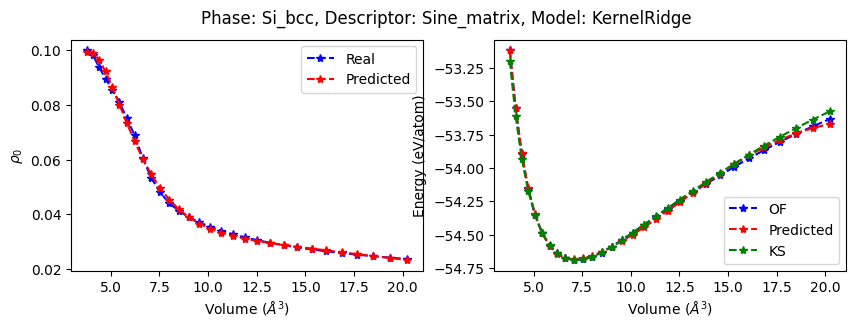

In [18]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_bcc
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Ewal_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.121982952391E+00      5.121983E+00    2.529854E+00    1       1       4.835606E-03    
1       4.670227091437E+00      -4.517559E-01   1.177824E-01    3       1       1.594782E-02    
2       4.657286760293E+00      -1.294033E-02   2.874532E-03    5       1       2.770376E-02    
3       4.657145540485E+00      -1.412198E-04   1.160652E-04    3       1       3.616858E-02    
4       4.657132887006E+00      -1.265348E-05   5.688647E-06    5       1       4.748225E-02    
5       4.657132349374E+00      -5.376321E-07   3.113244E-07    4       1       5.732322E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.81836153090

2       2.291080237930E+00      -1.169330E-02   6.702460E-03    6       1       3.197050E-02    
3       2.290551498341E+00      -5.287396E-04   6.609304E-04    4       1       4.316378E-02    
4       2.290476354563E+00      -7.514378E-05   4.071206E-05    6       1       5.761576E-02    
5       2.290473910370E+00      -2.444192E-06   3.451194E-06    3       1       6.686497E-02    
6       2.290473564450E+00      -3.459204E-07   2.085310E-07    5       1       7.957387E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.4301623152047616
Chemical potential (eV)  : 11.705311695274721
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.397220644184E+00      2.397221E+00    1.329625E+00    1       1       4.259348E-03    
1       2.085880810041E+00      -3.113398E-01   9.925410E-02    5       1       1.843238E-02    
2       2.072406907980E+00  

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.20337471421179737
Chemical potential (eV)  : 5.53410732795906
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.212375318915E+00      1.212375E+00    1.088331E+00    1       1       5.578279E-03    
1       6.770652270284E-01      -5.353101E-01   1.092429E-01    14      2       5.227304E-02    
2       6.677500360694E-01      -9.315191E-03   1.065409E-02    5       1       7.030177E-02    
3       6.662332317874E-01      -1.516804E-03   1.006103E-03    7       1       9.363055E-02    
4       6.661618022827E-01      -7.142950E-05   9.387917E-05    4       1       1.089928E-01    
5       6.661499474903E-01      -1.185479E-05   5.258095E-06    7       1       1.317770E-01    
6       6.661488695047E-01      -1.077986E-06   4.525062E-07    8       1       1.574216E-01    
#### Density Optimization Con

1       -3.158404504284E-01     -8.634208E-01   4.095793E-01    12      3       6.147885E-02    
2       -3.462558653606E-01     -3.041541E-02   2.379956E-02    4       1       8.033133E-02    
3       -3.477043841253E-01     -1.448519E-03   8.414565E-04    5       1       1.027622E-01    
4       -3.477785324779E-01     -7.414835E-05   7.141848E-05    6       1       1.284730E-01    
5       -3.477856294170E-01     -7.096939E-06   4.049703E-06    8       1       1.606562E-01    
6       -3.477858784943E-01     -2.490773E-07   2.874514E-07    5       1       1.828847E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05102595725082855
Chemical potential (eV)  : 1.3884868875284964
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.866646327088E-01      4.866646E-01    1.005774E+00    1       1       6.769896E-03    
1       -4.244378021608E-01

4       3.606148708258E+00      -1.381422E-04   7.273194E-05    6       1       5.298352E-02    
5       3.606144088528E+00      -4.619730E-06   4.800589E-06    4       1       6.409264E-02    
6       3.606143500275E+00      -5.882531E-07   1.184078E-07    6       1       7.850623E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.6448797227338383
Chemical potential (eV)  : 17.548069400195473
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.637375048149E+00      3.637375E+00    1.765606E+00    1       1       4.231453E-03    
1       3.325420165193E+00      -3.119549E-01   1.651740E-01    2       1       1.316595E-02    
2       3.307724722146E+00      -1.769544E-02   1.399371E-02    5       1       2.620769E-02    
3       3.306877037420E+00      -8.476847E-04   6.587645E-04    5       1       3.900623E-02    
4       3.306787944105E+00  

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.865997495968E+00      1.865997E+00    1.203131E+00    1       1       4.724503E-03    
1       1.486954433320E+00      -3.790431E-01   9.195076E-02    7       2       2.795053E-02    
2       1.481658123175E+00      -5.296310E-03   5.120206E-03    4       1       4.078102E-02    
3       1.481220213054E+00      -4.379101E-04   3.304117E-04    5       1       5.586386E-02    
4       1.481194974751E+00      -2.523830E-05   1.916431E-05    6       1       7.317591E-02    
5       1.481193527892E+00      -1.446859E-06   1.198243E-06    5       1       8.807540E-02    
6       1.481193305483E+00      -2.224095E-07   8.287898E-08    7       1       1.074159E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.30263791231038406
Chemical potential (eV)  : 8.235196271700397
setting key: Si -> /home/vr3

3       2.508826115752E-01      -3.868155E-03   1.293377E-03    8       1       8.989787E-02    
4       2.507952907388E-01      -8.732084E-05   6.190505E-05    4       1       1.049738E-01    
5       2.507887065526E-01      -6.584186E-06   2.455514E-06    6       1       1.252775E-01    
6       2.507881810017E-01      -5.255510E-07   1.025650E-07    9       1       1.534460E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.1252978822663682
Chemical potential (eV)  : 3.4095287170554083
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       8.351670755146E-01      8.351671E-01    1.042934E+00    1       1       5.584717E-03    
1       1.482204345245E-01      -6.869466E-01   2.807609E-01    12      2       4.607964E-02    
2       1.274237490746E-01      -2.079669E-02   2.193756E-02    5       1       6.374812E-02    
3       1.225216600184E-01  

7       -6.618928681413E-01     -1.691305E-07   9.498316E-08    6       1       2.655823E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.01635176619057554
Chemical potential (eV)  : 0.44495417953530436
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.254156792988E-01      3.254157E-01    9.882658E-01    1       1       6.718159E-03    
1       -6.221744169911E-02     -3.876331E-01   2.110447E+00    20      3       8.639336E-02    
2       -7.448221365201E-01     -6.826047E-01   1.263775E-01    17      2       1.520548E-01    
3       -7.614793475198E-01     -1.665721E-02   6.963902E-03    8       1       1.842864E-01    
4       -7.620552227923E-01     -5.758753E-04   6.440660E-04    4       1       2.027836E-01    
5       -7.621452545465E-01     -9.003175E-05   2.719655E-05    7       1       2.320995E-01    
6       -7.621486306278E-0

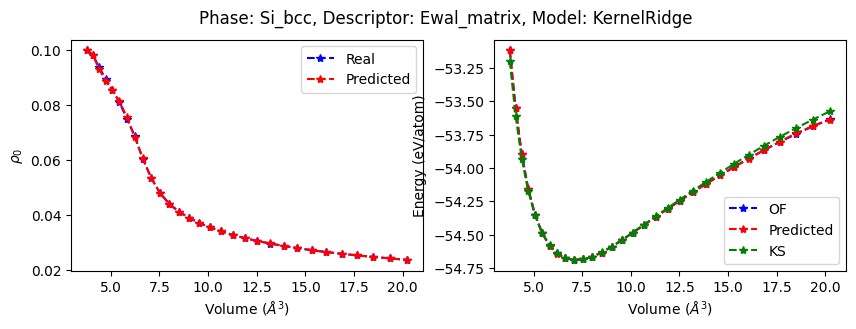

In [19]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_fcc
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Sine_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.587515867604E+01      1.587516E+01    8.746052E+00    1       1       5.403280E-03    
1       1.408884599495E+01      -1.786313E+00   3.390594E-01    4       2       2.117467E-02    
2       1.407194334210E+01      -1.690265E-02   2.539394E-02    3       1       3.096199E-02    
3       1.407054626229E+01      -1.397080E-03   2.184696E-03    4       1       4.241204E-02    
4       1.407041988416E+01      -1.263781E-04   9.707356E-05    5       1       5.591846E-02    
5       1.407041309767E+01      -6.786498E-06   7.586589E-06    4       1       6.722379E-02    
6       1.407041226152E+01      -8.361499E-07   2.014894E-07    6       1       8

1       7.762194189918E+00      -7.483560E-01   2.502383E-01    3       1       1.788139E-02    
2       7.732145754239E+00      -3.004844E-02   1.971863E-02    6       1       3.607488E-02    
3       7.730449284029E+00      -1.696470E-03   1.207527E-03    5       1       5.179453E-02    
4       7.730238006047E+00      -2.112780E-04   9.650753E-05    7       1       7.220936E-02    
5       7.730234610162E+00      -3.395885E-06   9.010772E-06    2       1       8.084130E-02    
6       7.730233887270E+00      -7.228924E-07   8.767324E-07    4       1       9.406972E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.6884700830975934
Chemical potential (eV)  : 18.734223409814433
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       7.900412842567E+00      7.900413E+00    3.844071E+00    1       1       5.352020E-03    
1       7.206947742193E+00  

6       4.083823816804E+00      -8.833067E-08   5.486154E-08    6       1       1.273336E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.39145326946695846
Chemical potential (eV)  : 10.651985009574812
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.404306568765E+00      4.404307E+00    2.554096E+00    1       1       6.298780E-03    
1       3.733283527311E+00      -6.710230E-01   1.579963E-01    7       2       3.495455E-02    
2       3.725558696199E+00      -7.724831E-03   1.382519E-02    3       1       4.805350E-02    
3       3.724073588238E+00      -1.485108E-03   9.591188E-04    5       1       6.638503E-02    
4       3.723961888587E+00      -1.116997E-04   9.392932E-05    6       1       8.768058E-02    
5       3.723951449585E+00      -1.043900E-05   8.939829E-06    6       1       1.091061E-01    
6       3.723950332625E+00 

2       1.319775893828E+00      -2.287872E-02   1.357845E-02    6       1       9.900117E-02    
3       1.317341801636E+00      -2.434092E-03   5.726575E-04    9       1       1.410477E-01    
4       1.317304226638E+00      -3.757500E-05   4.802799E-05    4       1       1.629286E-01    
5       1.317299051813E+00      -5.174825E-06   4.221707E-06    6       1       1.932464E-01    
6       1.317298412982E+00      -6.388311E-07   2.982828E-07    8       1       2.312007E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18150281143044142
Chemical potential (eV)  : 4.938942595077587
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.237867451665E+00      2.237867E+00    2.163819E+00    1       1       9.083509E-03    
1       1.098865881829E+00      -1.139002E+00   2.900918E-01    12      2       6.926584E-02    
2       1.068157823093E+00  

6       1.116864158329E+01      -2.022731E-07   1.429295E-07    4       1       8.135962E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.970009920974945
Chemical potential (eV)  : 26.395311888526976
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.153659821718E+01      1.153660E+01    5.858103E+00    1       1       4.777908E-03    
1       1.038920308396E+01      -1.147395E+00   3.344487E-01    4       2       1.922345E-02    
2       1.037050513303E+01      -1.869795E-02   1.802240E-02    4       1       3.041220E-02    
3       1.036880807302E+01      -1.697060E-03   1.107254E-03    5       1       4.314590E-02    
4       1.036873654455E+01      -7.152847E-05   8.174043E-05    4       1       5.413127E-02    
5       1.036872606755E+01      -1.047700E-05   3.082328E-06    6       1       6.852579E-02    
6       1.036872592887E+01   

1       5.735839019906E+00      -6.009846E-01   1.997794E-01    3       1       2.016640E-02    
2       5.708968174888E+00      -2.687085E-02   1.802470E-02    7       1       4.382181E-02    
3       5.707858277879E+00      -1.109897E-03   1.263858E-03    5       1       6.194687E-02    
4       5.707715402224E+00      -1.428757E-04   1.236354E-04    6       1       8.212757E-02    
5       5.707708119758E+00      -7.282466E-06   8.147199E-06    4       1       9.730649E-02    
6       5.707707176216E+00      -9.435419E-07   8.114128E-07    6       1       1.175983E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.5226293586795066
Chemical potential (eV)  : 14.221467869711331
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.891246840823E+00      5.891247E+00    3.018649E+00    1       1       6.181002E-03    
1       5.303663616004E+00  

6       2.732305269222E+00      -1.053375E-06   1.881200E-07    8       1       1.590993E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.28580658377086765
Chemical potential (eV)  : 7.777192537210474
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.282125970618E+00      3.282126E+00    2.317619E+00    1       1       7.337332E-03    
1       2.435291541798E+00      -8.468344E-01   1.309550E-01    9       2       4.793525E-02    
2       2.428275252338E+00      -7.016289E-03   7.759520E-03    4       1       6.748700E-02    
3       2.427408587193E+00      -8.666651E-04   6.066856E-04    6       1       9.271145E-02    
4       2.427322299980E+00      -8.628721E-05   6.021638E-05    7       1       1.215847E-01    
5       2.427315784680E+00      -6.515300E-06   4.148147E-06    6       1       1.472886E-01    
6       2.427314923919E+00  

2       3.638410175953E-01      -7.868774E-02   4.414803E-02    6       1       9.750009E-02    
3       3.568919343123E-01      -6.949083E-03   3.424519E-03    8       1       1.351359E-01    
4       3.565903006340E-01      -3.016337E-04   2.969798E-04    5       1       1.610215E-01    
5       3.565486235957E-01      -4.167704E-05   1.262242E-05    7       1       1.945851E-01    
6       3.565468184086E-01      -1.805187E-06   1.220834E-06    5       1       2.203856E-01    
7       3.565465762498E-01      -2.421588E-07   5.839373E-08    9       1       2.618468E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.11604648725684394
Chemical potential (eV)  : 3.15778546020818


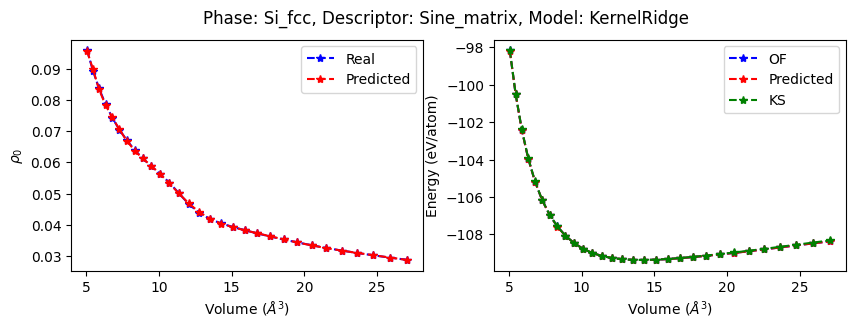

In [20]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_fcc
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Ewal_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.587515867604E+01      1.587516E+01    8.746052E+00    1       1       5.183458E-03    
1       1.408884599495E+01      -1.786313E+00   3.390594E-01    4       2       2.025771E-02    
2       1.407194334210E+01      -1.690265E-02   2.539394E-02    3       1       2.980208E-02    
3       1.407054626229E+01      -1.397080E-03   2.184696E-03    4       1       4.110789E-02    
4       1.407041988416E+01      -1.263781E-04   9.707356E-05    5       1       5.376863E-02    
5       1.407041309767E+01      -6.786498E-06   7.586589E-06    4       1       6.477213E-02    
6       1.407041226152E+01      -8.361499E-07   2.014894E-07    6       1       7

1       7.762194189918E+00      -7.483560E-01   2.502383E-01    3       1       1.731133E-02    
2       7.732145754239E+00      -3.004844E-02   1.971863E-02    6       1       3.479838E-02    
3       7.730449284029E+00      -1.696470E-03   1.207527E-03    5       1       4.993558E-02    
4       7.730238006047E+00      -2.112780E-04   9.650753E-05    7       1       6.942987E-02    
5       7.730234610162E+00      -3.395885E-06   9.010772E-06    2       1       7.767296E-02    
6       7.730233887270E+00      -7.228924E-07   8.767324E-07    4       1       9.022021E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.6884700830975934
Chemical potential (eV)  : 18.734223409814433
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       7.900412842567E+00      7.900413E+00    3.844071E+00    1       1       5.296469E-03    
1       7.206947742193E+00  

6       4.083823816804E+00      -8.833067E-08   5.486154E-08    6       1       1.265950E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.39145326946695846
Chemical potential (eV)  : 10.651985009574812
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.404306568765E+00      4.404307E+00    2.554096E+00    1       1       6.086111E-03    
1       3.733283527311E+00      -6.710230E-01   1.579963E-01    7       2       3.344631E-02    
2       3.725558696199E+00      -7.724831E-03   1.382519E-02    3       1       4.601932E-02    
3       3.724073588238E+00      -1.485108E-03   9.591188E-04    5       1       6.358480E-02    
4       3.723961888587E+00      -1.116997E-04   9.392932E-05    6       1       8.388114E-02    
5       3.723951449585E+00      -1.043900E-05   8.939829E-06    6       1       1.041160E-01    
6       3.723950332625E+00 

2       1.319775893828E+00      -2.287872E-02   1.357845E-02    6       1       1.005428E-01    
3       1.317341801636E+00      -2.434092E-03   5.726575E-04    9       1       1.422296E-01    
4       1.317304226638E+00      -3.757500E-05   4.802799E-05    4       1       1.639359E-01    
5       1.317299051813E+00      -5.174825E-06   4.221707E-06    6       1       1.938365E-01    
6       1.317298412982E+00      -6.388311E-07   2.982828E-07    8       1       2.317486E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.18150281143044142
Chemical potential (eV)  : 4.938942595077587
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.237867451665E+00      2.237867E+00    2.163819E+00    1       1       8.387089E-03    
1       1.098865881829E+00      -1.139002E+00   2.900918E-01    12      2       6.733799E-02    
2       1.068157823093E+00  

6       1.117124406227E+01      -1.889726E-07   1.343774E-07    4       1       8.126473E-02    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.9703044694500063
Chemical potential (eV)  : 26.403326960019974
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.153659821718E+01      1.153660E+01    5.858103E+00    1       1       4.733324E-03    
1       1.038928205166E+01      -1.147316E+00   3.343135E-01    4       2       1.904368E-02    
2       1.037059301683E+01      -1.868903E-02   1.801296E-02    4       1       3.021431E-02    
3       1.036889713048E+01      -1.695886E-03   1.105840E-03    5       1       4.285359E-02    
4       1.036882569826E+01      -7.143222E-05   8.161177E-05    4       1       5.376601E-02    
5       1.036881524024E+01      -1.045802E-05   3.075165E-06    6       1       6.842446E-02    
6       1.036881510185E+01  

1       5.735839722889E+00      -6.009839E-01   1.997285E-01    3       1       2.042985E-02    
2       5.708987376341E+00      -2.685235E-02   1.799564E-02    7       1       4.353356E-02    
3       5.707879078315E+00      -1.108298E-03   1.262529E-03    5       1       6.130934E-02    
4       5.707736416990E+00      -1.426613E-04   1.233710E-04    6       1       8.174872E-02    
5       5.707729146633E+00      -7.270357E-06   8.126096E-06    4       1       9.665728E-02    
6       5.707728205076E+00      -9.415574E-07   8.080907E-07    6       1       1.171207E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.5226313903669962
Chemical potential (eV)  : 14.22152315473862
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.891246840823E+00      5.891247E+00    3.018649E+00    1       1       6.188869E-03    
1       5.303668514580E+00   

6       2.732048863298E+00      -1.051736E-06   1.884908E-07    8       1       1.584232E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.2857869764331209
Chemical potential (eV)  : 7.776658994425047
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       3.282125970618E+00      3.282126E+00    2.317619E+00    1       1       7.272243E-03    
1       2.435144458496E+00      -8.469815E-01   1.310265E-01    9       2       4.810476E-02    
2       2.428123680510E+00      -7.020778E-03   7.764942E-03    4       1       6.714892E-02    
3       2.427256424877E+00      -8.672556E-04   6.071178E-04    6       1       9.240699E-02    
4       2.427170026896E+00      -8.639798E-05   6.033576E-05    7       1       1.213589E-01    
5       2.427163498741E+00      -6.528155E-06   4.156752E-06    6       1       1.469200E-01    
6       2.427162635841E+00   

2       3.635038098792E-01      -7.872542E-02   4.419036E-02    6       1       9.731770E-02    
3       3.565452605704E-01      -6.958549E-03   3.431522E-03    8       1       1.349270E-01    
4       3.562429963760E-01      -3.022642E-04   2.976094E-04    5       1       1.608772E-01    
5       3.562012276078E-01      -4.176877E-05   1.265621E-05    7       1       1.946094E-01    
6       3.561994178910E-01      -1.809717E-06   1.224441E-06    5       1       2.207947E-01    
7       3.561991750935E-01      -2.427975E-07   5.840133E-08    9       1       2.629285E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.11602471792376333
Chemical potential (eV)  : 3.1571930865387534


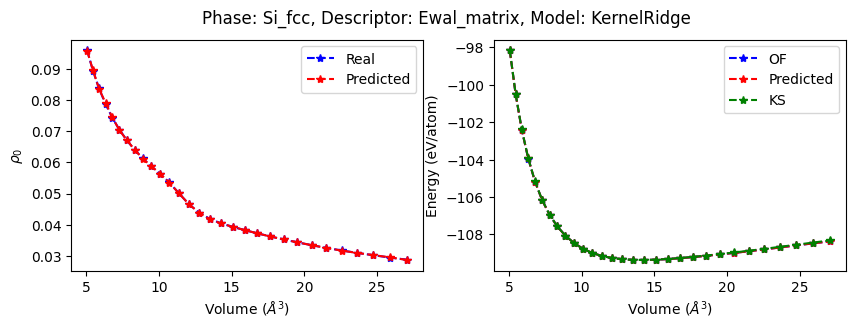

In [21]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_8cd
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Sine_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.438148381693E+01      1.438148E+01    9.442400E+00    1       1       8.946180E-03    
1       1.095919848045E+01      -3.422285E+00   4.620969E-01    10      2       5.742121E-02    
2       1.093259169260E+01      -2.660679E-02   2.660987E-02    4       1       7.785201E-02    
3       1.092975277150E+01      -2.838921E-03   1.805940E-03    6       1       1.049905E-01    
4       1.092952542770E+01      -2.273438E-04   8.944744E-05    7       1       1.347401E-01    
5       1.092951669693E+01      -8.730773E-06   6.958859E-06    5       1       1.571784E-01    
6       1.092951582659E+01      -8.703350E-07   4.629282E-07    6       1       1

1       2.623601747765E+00      -4.239594E+00   3.130754E-01    16      2       1.350846E-01    
2       2.519898834125E+00      -1.037029E-01   2.326253E-02    7       1       1.918709E-01    
3       2.518353493648E+00      -1.545340E-03   2.197631E-03    4       1       2.277334E-01    
4       2.518129285959E+00      -2.242077E-04   1.209203E-04    6       1       2.773542E-01    
5       2.518120001417E+00      -9.284543E-06   7.406038E-06    6       1       3.270504E-01    
6       2.518119315917E+00      -6.854995E-07   7.176451E-07    6       1       3.763976E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.23810496041469412
Chemical potential (eV)  : 6.479165373931837
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.245632050754E+00      6.245632E+00    7.245662E+00    1       1       1.093531E-02    
1       1.903087737899E+00  

5       -2.493859369433E+00     -4.336111E-05   2.314462E-05    10      1       8.685427E-01    
6       -2.493860794579E+00     -1.425146E-06   1.673375E-06    4       1       9.346888E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.07701207306904524
Chemical potential (eV)  : 2.0956050488600964
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.739826537458E+00      2.739827E+00    6.425248E+00    1       1       1.796126E-02    
1       -2.684239632746E+00     -5.424066E+00   4.783940E+00    12      2       1.855552E-01    
2       -2.954573197694E+00     -2.703336E-01   4.137847E-01    3       1       2.371652E-01    
3       -2.994445078404E+00     -3.987188E-02   1.361568E-02    5       1       3.155460E-01    
4       -2.997642303112E+00     -3.197225E-03   1.082414E-03    10      1       4.550362E-01    
5       -2.997731720119E+00

0       9.848765732985E-01      9.848766E-01    5.914265E+00    1       1       2.167368E-02    
!WARN : pAp small than zero :iter =  8 -135858.65687983658
1       -4.698613348173E+00     -5.683490E+00   1.217676E+01    9       2       1.810710E-01    
2       -5.818486684416E+00     -1.119873E+00   1.064727E+00    5       1       2.711983E-01    
3       -6.029746789908E+00     -2.112601E-01   7.924095E-02    9       1       4.191813E-01    
4       -6.040237847680E+00     -1.049106E-02   5.114026E-03    12      1       6.016676E-01    
5       -6.040700194686E+00     -4.623470E-04   4.757541E-04    5       1       6.906683E-01    
6       -6.040763510912E+00     -6.331623E-05   3.094048E-05    7       1       8.099937E-01    
7       -6.040767144490E+00     -3.633578E-06   1.460602E-06    8       1       9.438832E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.019060198351567758
Chemical potential (eV)  : -0.5186543655565494
setting key: Si -> /home/vr3

3       9.561324180098E+00      -3.688765E-03   2.913717E-03    5       1       1.006086E-01    
4       9.560963439617E+00      -3.607405E-04   1.587672E-04    7       1       1.311579E-01    
5       9.560953797465E+00      -9.642152E-06   1.356285E-05    4       1       1.505296E-01    
6       9.560952333444E+00      -1.464021E-06   7.514919E-07    6       1       1.762543E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.48856310740538383
Chemical potential (eV)  : 13.294478044339613
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.195002006905E+01      1.195002E+01    8.724591E+00    1       1       9.695053E-03    
1       8.353036552617E+00      -3.596984E+00   5.077539E-01    11      2       7.064033E-02    
2       8.309667382919E+00      -4.336917E-02   3.140823E-02    5       1       9.843993E-02    
3       8.306757517130E+00 

Chemical potential (a.u.): 0.21270541967663276
Chemical potential (eV)  : 5.788008732015601
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.677187336606E+00      5.677187E+00    7.108708E+00    1       1       1.511669E-02    
1       1.212362449773E+00      -4.464825E+00   3.318361E-01    18      2       1.857283E-01    
2       1.064594292046E+00      -1.477682E-01   2.398268E-02    8       1       2.631304E-01    
3       1.063103704181E+00      -1.490588E-03   2.069692E-03    5       1       3.147068E-01    
4       1.062908694568E+00      -1.950096E-04   9.479743E-05    7       1       3.865042E-01    
5       1.062904361542E+00      -4.333027E-06   7.563096E-06    4       1       4.316294E-01    
6       1.062903172515E+00      -1.189026E-06   6.526559E-07    7       1       5.014272E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0

0       2.432961884068E+00      2.432962E+00    6.346900E+00    1       1       1.770520E-02    
1       -5.336004570151E-01     -2.966562E+00   2.522551E+01    13      5       2.228749E-01    
2       -3.343283035730E+00     -2.809683E+00   1.340851E+00    8       1       3.355963E-01    
3       -3.470728467595E+00     -1.274454E-01   1.299104E-01    8       1       4.449923E-01    
4       -3.478639911912E+00     -7.911444E-03   1.140257E-02    4       1       5.065246E-01    
5       -3.481570681346E+00     -2.930769E-03   8.446249E-04    11      2       6.613095E-01    
6       -3.481631148721E+00     -6.046737E-05   6.133068E-05    4       1       7.222335E-01    
7       -3.481635222435E+00     -4.073714E-06   4.836270E-06    5       1       7.960968E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.04820971322001064
Chemical potential (eV)  : 1.3118529913793444
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)       

4       -6.415602143399E+00     -6.020977E-02   2.134013E-02    14      2       5.985396E-01    
5       -6.417206775842E+00     -1.604632E-03   1.907229E-03    5       1       7.338221E-01    
6       -6.417684632608E+00     -4.778568E-04   1.632498E-04    8       2       8.805008E-01    
7       -6.417716908591E+00     -3.227598E-05   8.082609E-06    10      1       1.040409E+00    
8       -6.417719033125E+00     -2.124534E-06   6.851949E-07    8       1       1.173704E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.02796194046952061
Chemical potential (eV)  : -0.7608830835045499
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.197660650333E-01      6.197661E-01    5.783090E+00    1       1       2.085733E-02    
!WARN : pAp small than zero :iter =  7 -359327.0184017577
1       -5.524377891868E+00     -6.144144E+00   1.173811E+01    

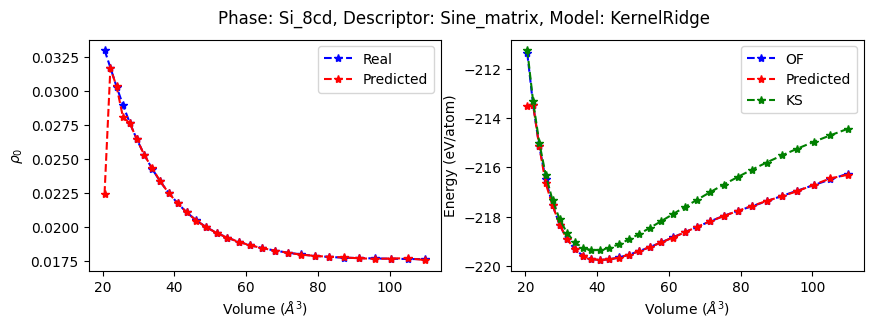

In [22]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_8cd
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Ewal_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.438148381693E+01      1.438148E+01    9.442400E+00    1       1       9.494066E-03    
1       1.095919848045E+01      -3.422285E+00   4.620969E-01    10      2       5.768418E-02    
2       1.093259169260E+01      -2.660679E-02   2.660987E-02    4       1       7.832146E-02    
3       1.092975277150E+01      -2.838921E-03   1.805940E-03    6       1       1.054745E-01    
4       1.092952542770E+01      -2.273438E-04   8.944744E-05    7       1       1.355019E-01    
5       1.092951669693E+01      -8.730773E-06   6.958859E-06    5       1       1.581557E-01    
6       1.092951582659E+01      -8.703350E-07   4.629282E-07    6       1       1

1       2.623601747765E+00      -4.239594E+00   3.130754E-01    16      2       1.361651E-01    
2       2.519898834125E+00      -1.037029E-01   2.326253E-02    7       1       1.942816E-01    
3       2.518353493648E+00      -1.545340E-03   2.197631E-03    4       1       2.313600E-01    
4       2.518129285959E+00      -2.242077E-04   1.209203E-04    6       1       2.819080E-01    
5       2.518120001417E+00      -9.284543E-06   7.406038E-06    6       1       3.333321E-01    
6       2.518119315917E+00      -6.854995E-07   7.176451E-07    6       1       3.853827E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.23810496041469412
Chemical potential (eV)  : 6.479165373931837
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.245632050754E+00      6.245632E+00    7.245662E+00    1       1       1.120615E-02    
1       1.903087737899E+00  

5       -2.493859369433E+00     -4.336111E-05   2.314462E-05    10      1       8.664694E-01    
6       -2.493860794579E+00     -1.425146E-06   1.673375E-06    4       1       9.318032E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.07701207306904524
Chemical potential (eV)  : 2.0956050488600964
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.739826537458E+00      2.739827E+00    6.425248E+00    1       1       1.868820E-02    
1       -2.684239632746E+00     -5.424066E+00   4.783940E+00    12      2       1.883583E-01    
2       -2.954573197694E+00     -2.703336E-01   4.137847E-01    3       1       2.415338E-01    
3       -2.994445078404E+00     -3.987188E-02   1.361568E-02    5       1       3.192470E-01    
4       -2.997642303112E+00     -3.197225E-03   1.082414E-03    10      1       4.582806E-01    
5       -2.997731720119E+00

0       9.848765732985E-01      9.848766E-01    5.914265E+00    1       1       2.114916E-02    
!WARN : pAp small than zero :iter =  8 -135858.65687983658
1       -4.698613348173E+00     -5.683490E+00   1.217676E+01    9       2       2.491188E-01    
2       -5.818486684416E+00     -1.119873E+00   1.064727E+00    5       1       3.410172E-01    
3       -6.029746789908E+00     -2.112601E-01   7.924095E-02    9       1       4.880571E-01    
4       -6.040237847680E+00     -1.049106E-02   5.114026E-03    12      1       6.725135E-01    
5       -6.040700194686E+00     -4.623470E-04   4.757541E-04    5       1       7.612791E-01    
6       -6.040763510912E+00     -6.331623E-05   3.094048E-05    7       1       8.817112E-01    
7       -6.040767144490E+00     -3.633578E-06   1.460602E-06    8       1       1.015642E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.019060198351567758
Chemical potential (eV)  : -0.5186543655565494
setting key: Si -> /home/vr3

3       9.560832542225E+00      -3.690864E-03   2.917845E-03    5       1       9.773660E-02    
4       9.560471153363E+00      -3.613889E-04   1.591580E-04    7       1       1.275830E-01    
5       9.560461486402E+00      -9.666961E-06   1.359574E-05    4       1       1.466041E-01    
6       9.560460019372E+00      -1.467030E-06   7.535853E-07    6       1       1.721489E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.488550401242625
Chemical potential (eV)  : 13.294132292072884
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.195002006905E+01      1.195002E+01    8.724591E+00    1       1       1.005459E-02    
1       8.353991825729E+00      -3.596028E+00   5.075891E-01    11      2       7.036734E-02    
2       8.310648344768E+00      -4.334348E-02   3.137761E-02    5       1       9.779358E-02    
3       8.307744484428E+00   

Chemical potential (a.u.): 0.21273582714752357
Chemical potential (eV)  : 5.788836161365084
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.677187336606E+00      5.677187E+00    7.108708E+00    1       1       1.413131E-02    
1       1.213477025712E+00      -4.463710E+00   3.315580E-01    18      2       1.836321E-01    
2       1.065763734949E+00      -1.477133E-01   2.395266E-02    8       1       2.615972E-01    
3       1.064275068649E+00      -1.488666E-03   2.072103E-03    5       1       3.143620E-01    
4       1.064079649700E+00      -1.954189E-04   9.543330E-05    7       1       3.844478E-01    
5       1.064075297432E+00      -4.352268E-06   7.638785E-06    4       1       4.294579E-01    
6       1.064074102517E+00      -1.194915E-06   6.574406E-07    7       1       5.000272E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0

Chemical potential (eV)  : 1.684045535384559
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.432961884068E+00      2.432962E+00    6.346900E+00    1       1       1.784635E-02    
!WARN : pAp small than zero :iter =  8 -6781353.317802044
1       -5.720975097387E+00     -8.153937E+00   9.385902E+00    9       4       1.726553E-01    
2       -6.613500803034E+00     -8.925257E-01   5.364034E-01    5       1       2.493453E-01    
3       -6.685056674212E+00     -7.155587E-02   4.694613E-02    8       1       3.600540E-01    
4       -6.689668943107E+00     -4.612269E-03   3.520836E-03    7       1       4.583352E-01    
5       -6.690363275819E+00     -6.943327E-04   2.453283E-04    10      1       5.907729E-01    
6       -6.690388354522E+00     -2.507870E-05   1.325426E-05    6       1       6.766167E-01    
7       -6.690390907988E+00     -2.553465E-06   8.033897E-

!WARN : pAp small than zero :iter =  5 -1959484.9771717754
1       -8.657247742183E+00     -9.453506E+00   1.050942E+01    6       4       1.684928E-01    
2       -9.280523369396E+00     -6.232756E-01   8.845070E-01    3       1       2.303491E-01    
3       -9.324330714287E+00     -4.380734E-02   6.344056E-02    4       1       3.066185E-01    
4       -9.336848122876E+00     -1.251741E-02   4.754346E-03    9       2       4.670758E-01    
5       -9.337377269714E+00     -5.291468E-04   4.559879E-04    6       1       5.702403E-01    
6       -9.337454525820E+00     -7.725611E-05   3.510722E-05    8       1       7.055757E-01    
7       -9.337460055323E+00     -5.529503E-06   2.413481E-06    7       1       8.251672E-01    
8       -9.337460747010E+00     -6.916868E-07   1.944616E-07    10      1       9.854498E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.13072487025627433
Chemical potential (eV)  : -3.5572045681074123
setting key: Si -> /home/vr37

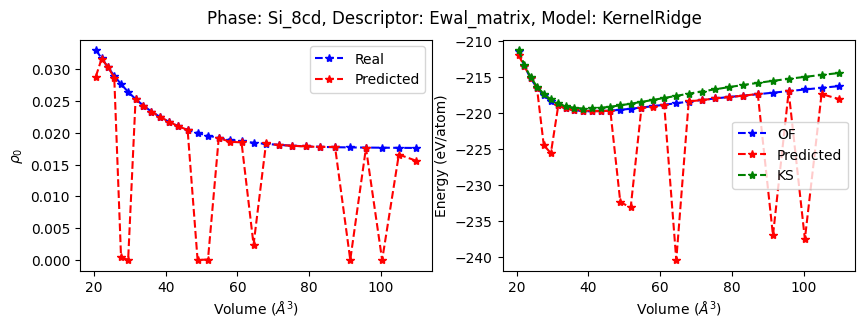

In [23]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_7cd
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Sine_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.069037940720E+01      1.069038E+01    9.627248E+00    1       1       9.455442E-03    
1       7.059163690596E+00      -3.631216E+00   5.850099E-01    12      2       6.688523E-02    
2       6.919199765901E+00      -1.399639E-01   2.882876E-02    8       1       1.015761E-01    
3       6.915816771432E+00      -3.382994E-03   2.537048E-03    6       1       1.282189E-01    
4       6.915520002783E+00      -2.967686E-04   2.278730E-04    7       1       1.575234E-01    
5       6.915501202345E+00      -1.880044E-05   1.495936E-05    5       1       1.802077E-01    
6       6.915498131312E+00      -3.071033E-06   9.758607E-07    8       1       2

Chemical potential (eV)  : 5.779841857239307
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.908615370479E+00      4.908615E+00    7.799938E+00    1       1       1.144028E-02    
1       6.582536911419E-01      -4.250362E+00   4.349228E+00    12      2       1.101274E-01    
2       2.906973791338E-01      -3.675563E-01   3.658983E-01    5       1       1.535027E-01    
3       2.401061115714E-01      -5.059127E-02   2.471814E-02    8       1       2.175944E-01    
4       2.383078741499E-01      -1.798237E-03   2.091406E-03    5       1       2.601931E-01    
5       2.379865647524E-01      -3.213094E-04   1.907276E-04    7       1       3.172181E-01    
6       2.379697823277E-01      -1.678242E-05   1.446106E-05    5       1       3.604443E-01    
7       2.379669211245E-01      -2.861203E-06   1.182368E-06    8       1       4.238944E-01    
#### Density Optimi

4       -3.387199138052E+00     -1.218595E-02   5.309761E-03    10      1       5.523024E-01    
5       -3.387619762169E+00     -4.206241E-04   3.256724E-04    8       1       6.707730E-01    
6       -3.387668411982E+00     -4.864981E-05   1.771285E-05    10      1       8.126848E-01    
7       -3.387671072348E+00     -2.660366E-06   1.611136E-06    8       1       9.287212E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.056970584182381004
Chemical potential (eV)  : 1.5502484102988567
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.004639723414E+00      2.004640E+00    6.774887E+00    1       1       1.788354E-02    
1       -1.525714570960E+00     -3.530354E+00   2.380201E+01    13      4       2.153594E-01    
2       -3.728571267322E+00     -2.202857E+00   1.159759E+00    8       1       3.286021E-01    
3       -3.805734628051E+0

7       -6.075730213292E+00     -3.111042E-06   2.946704E-06    6       1       7.913029E-01    
8       -6.075730654524E+00     -4.412321E-07   2.612164E-07    8       1       9.007235E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.024668139356102407
Chemical potential (eV)  : -0.6712541984720467
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.713396014348E-01      5.713396E-01    6.101863E+00    1       1       2.126169E-02    
!WARN : pAp small than zero :iter =  6 -64850.3148839583
1       -5.313609470362E+00     -5.884949E+00   1.122661E+01    7       2       1.587534E-01    
2       -6.190101757805E+00     -8.764923E-01   9.402792E-01    4       1       2.334983E-01    
3       -6.400152547472E+00     -2.100508E-01   7.092389E-02    10      2       4.079671E-01    
4       -6.409330238068E+00     -9.177691E-03   5.961886E-03    

7       -8.179663993144E+00     -3.990879E-06   3.092731E-06    6       1       1.096882E+00    
8       -8.179664526159E+00     -5.330153E-07   2.784472E-07    10      1       1.277868E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.07483013699412391
Chemical potential (eV)  : -2.036231549710221
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.069037940720E+01      1.069038E+01    9.627248E+00    1       1       9.451151E-03    
1       7.058708402035E+00      -3.631671E+00   5.850956E-01    12      2       6.828976E-02    
2       6.918685199565E+00      -1.400232E-01   2.885714E-02    8       1       1.058364E-01    
3       6.915297344427E+00      -3.387855E-03   2.541780E-03    6       1       1.342700E-01    
4       6.914999866573E+00      -2.974779E-04   2.286800E-04    7       1       1.651096E-01    
5       6.914980999636E+00

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.21240467062923135
Chemical potential (eV)  : 5.779824934371182
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.908615370479E+00      4.908615E+00    7.799938E+00    1       1       1.164556E-02    
1       6.579894016187E-01      -4.250626E+00   4.350218E+00    12      2       1.145005E-01    
2       2.903376463050E-01      -3.676518E-01   3.660392E-01    5       1       1.569357E-01    
3       2.397252347248E-01      -5.061241E-02   2.473407E-02    8       1       2.223384E-01    
4       2.379257183153E-01      -1.799516E-03   2.093059E-03    5       1       2.662914E-01    
5       2.376041107909E-01      -3.216075E-04   1.909471E-04    7       1       3.233356E-01    
6       2.375873098172E-01      -1.680097E-05   1.447870E-05    5       1       3.672519E-01    
7       2.375844446284E-01  

3       -3.375378249906E+00     -8.031220E-02   8.119478E-02    4       1       4.145484E-01    
4       -3.387566875003E+00     -1.218863E-02   5.311194E-03    10      1       5.533836E-01    
5       -3.387987682072E+00     -4.208071E-04   3.258117E-04    8       1       6.694109E-01    
6       -3.388036360453E+00     -4.867838E-05   1.772656E-05    10      1       8.081496E-01    
7       -3.388039023837E+00     -2.663384E-06   1.614026E-06    8       1       9.699326E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.056961385896388
Chemical potential (eV)  : 1.5499981122118216
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.004639723414E+00      2.004640E+00    6.774887E+00    1       1       1.750875E-02    
1       -1.525770935045E+00     -3.530411E+00   2.380416E+01    13      4       2.185843E-01    
2       -3.728875908377E+00  

6       -6.075093391273E+00     -1.162752E-04   3.815908E-05    12      1       7.538652E-01    
7       -6.075096499267E+00     -3.107995E-06   2.944290E-06    6       1       8.396740E-01    
8       -6.075096940074E+00     -4.408064E-07   2.610924E-07    8       1       9.509671E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.024652331040871542
Chemical potential (eV)  : -0.6708240323449504
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.713396014348E-01      5.713396E-01    6.101863E+00    1       1       2.103400E-02    
!WARN : pAp small than zero :iter =  6 -64128.41127031621
1       -5.312947752245E+00     -5.884287E+00   1.122553E+01    7       2       2.179585E-01    
2       -6.189280649876E+00     -8.763329E-01   9.400225E-01    4       1       3.433175E-01    
3       -6.399231574504E+00     -2.099509E-01   7.084901E-02   

6       -8.186219986065E+00     -9.488842E-05   4.449170E-05    12      1       9.679387E-01    
7       -8.186224088668E+00     -4.102603E-06   3.134341E-06    6       1       1.133145E+00    
8       -8.186224618147E+00     -5.294797E-07   2.615629E-07    10      1       1.312872E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.07495223889839439
Chemical potential (eV)  : -2.039554111444603


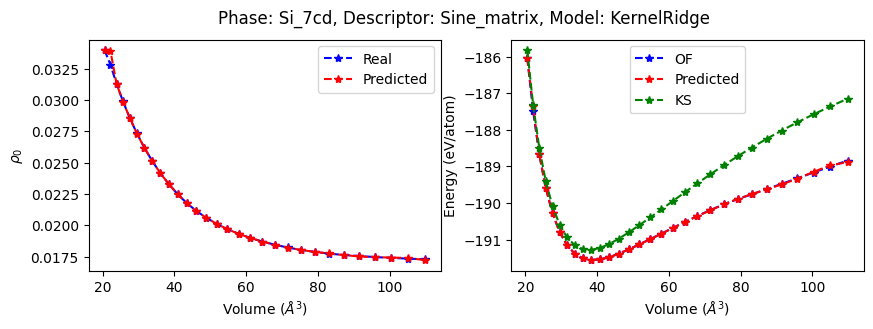

In [24]:
if __name__ == '__main__':
    main()

Please type in the Phase of silicon you want to study:Si_7cd
Please type The regression model you want to use:KernelRidge
Please type The descriptor you want to use:Ewal_matrix
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.069037940720E+01      1.069038E+01    9.627248E+00    1       1       9.437799E-03    
1       7.059163690596E+00      -3.631216E+00   5.850099E-01    12      2       6.767368E-02    
2       6.919199765901E+00      -1.399639E-01   2.882876E-02    8       1       1.040468E-01    
3       6.915816771432E+00      -3.382994E-03   2.537048E-03    6       1       1.303644E-01    
4       6.915520002783E+00      -2.967686E-04   2.278730E-04    7       1       1.597393E-01    
5       6.915501202345E+00      -1.880044E-05   1.495936E-05    5       1       1.824210E-01    
6       6.915498131312E+00      -3.071033E-06   9.758607E-07    8       1       2

Chemical potential (eV)  : 5.779841857239307
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.908615370479E+00      4.908615E+00    7.799938E+00    1       1       1.128125E-02    
1       6.582536911419E-01      -4.250362E+00   4.349228E+00    12      2       1.128263E-01    
2       2.906973791338E-01      -3.675563E-01   3.658983E-01    5       1       1.567042E-01    
3       2.401061115714E-01      -5.059127E-02   2.471814E-02    8       1       2.203615E-01    
4       2.383078741499E-01      -1.798237E-03   2.091406E-03    5       1       2.629709E-01    
5       2.379865647524E-01      -3.213094E-04   1.907276E-04    7       1       3.196087E-01    
6       2.379697823277E-01      -1.678242E-05   1.446106E-05    5       1       3.623452E-01    
7       2.379669211245E-01      -2.861203E-06   1.182368E-06    8       1       4.255717E-01    
#### Density Optimi

4       -3.387199138052E+00     -1.218595E-02   5.309761E-03    10      1       6.046484E-01    
5       -3.387619762169E+00     -4.206241E-04   3.256724E-04    8       1       7.194920E-01    
6       -3.387668411982E+00     -4.864981E-05   1.771285E-05    10      1       8.605359E-01    
7       -3.387671072348E+00     -2.660366E-06   1.611136E-06    8       1       9.744139E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.056970584182381004
Chemical potential (eV)  : 1.5502484102988567
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.004639723414E+00      2.004640E+00    6.774887E+00    1       1       1.931739E-02    
1       -1.525714570960E+00     -3.530354E+00   2.380201E+01    13      4       2.333472E-01    
2       -3.728571267322E+00     -2.202857E+00   1.159759E+00    8       1       3.559637E-01    
3       -3.805734628051E+0

7       -6.075730213292E+00     -3.111042E-06   2.946704E-06    6       1       8.049514E-01    
8       -6.075730654524E+00     -4.412321E-07   2.612164E-07    8       1       9.136796E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.024668139356102407
Chemical potential (eV)  : -0.6712541984720467
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.713396014348E-01      5.713396E-01    6.101863E+00    1       1       2.104163E-02    
!WARN : pAp small than zero :iter =  6 -64850.3148839583
1       -5.313609470362E+00     -5.884949E+00   1.122661E+01    7       2       1.514993E-01    
2       -6.190101757805E+00     -8.764923E-01   9.402792E-01    4       1       2.262690E-01    
3       -6.400152547472E+00     -2.100508E-01   7.092389E-02    10      2       3.987541E-01    
4       -6.409330238068E+00     -9.177691E-03   5.961886E-03    

7       -8.179663993144E+00     -3.990879E-06   3.092731E-06    6       1       1.124776E+00    
8       -8.179664526159E+00     -5.330153E-07   2.784472E-07    10      1       1.303807E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.07483013699412391
Chemical potential (eV)  : -2.036231549710221
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.069037940720E+01      1.069038E+01    9.627248E+00    1       1       8.666754E-03    
1       7.058572746851E+00      -3.631807E+00   5.851207E-01    12      2       6.434464E-02    
2       6.918531874672E+00      -1.400409E-01   2.886584E-02    8       1       9.977388E-02    
3       6.915142563561E+00      -3.389311E-03   2.543225E-03    6       1       1.269209E-01    
4       6.914844871922E+00      -2.976916E-04   2.289022E-04    7       1       1.560791E-01    
5       6.914825985384E+00

#### Density Optimization Converged ####
Chemical potential (a.u.): 0.21238049745227625
Chemical potential (eV)  : 5.779167148784386
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.908615370479E+00      4.908615E+00    7.799938E+00    1       1       1.102948E-02    
1       6.583755136258E-01      -4.250240E+00   4.348771E+00    12      2       1.088917E-01    
2       2.908630304720E-01      -3.675125E-01   3.658259E-01    5       1       1.515889E-01    
3       2.402817408894E-01      -5.058129E-02   2.471085E-02    8       1       2.152574E-01    
4       2.384840814701E-01      -1.797659E-03   2.090641E-03    5       1       2.584684E-01    
5       2.381629036600E-01      -3.211778E-04   1.906356E-04    7       1       3.149102E-01    
6       2.381461290572E-01      -1.677460E-05   1.445296E-05    5       1       3.579674E-01    
7       2.381432695275E-01  

3       -3.374875028547E+00     -8.027992E-02   8.116332E-02    4       1       4.108088E-01    
4       -3.387059969510E+00     -1.218494E-02   5.309087E-03    10      1       5.473013E-01    
5       -3.387480523895E+00     -4.205544E-04   3.256049E-04    8       1       6.600597E-01    
6       -3.387529162470E+00     -4.863858E-05   1.770692E-05    10      1       7.970545E-01    
7       -3.387531821986E+00     -2.659517E-06   1.609875E-06    8       1       9.108212E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05697406317598609
Chemical potential (eV)  : 1.550343078527788
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.004639723414E+00      2.004640E+00    6.774887E+00    1       1       1.721311E-02    
1       -1.525742224569E+00     -3.530382E+00   2.380306E+01    13      4       2.140622E-01    
2       -3.728720713448E+00 

6       -6.075600202611E+00     -1.163178E-04   3.818351E-05    12      1       7.071700E-01    
7       -6.075603313014E+00     -3.110404E-06   2.946266E-06    6       1       7.915576E-01    
8       -6.075603754089E+00     -4.410746E-07   2.611917E-07    8       1       9.001567E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.024665019096421065
Chemical potential (eV)  : -0.6711692918894631
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       5.713396014348E-01      5.713396E-01    6.101863E+00    1       1       2.096772E-02    
!WARN : pAp small than zero :iter =  6 -65842.45622209298
1       -5.314510533971E+00     -5.885850E+00   1.122809E+01    7       2       1.536298E-01    
2       -6.191220430146E+00     -8.767099E-01   9.406217E-01    4       1       2.312770E-01    
3       -6.401407514737E+00     -2.101871E-01   7.101707E-02   

6       -8.186714038759E+00     -9.497867E-05   4.459138E-05    12      1       9.574735E-01    
7       -8.186718149897E+00     -4.111139E-06   3.138539E-06    6       1       1.140472E+00    
8       -8.186718679040E+00     -5.291429E-07   2.602752E-07    10      1       1.327727E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.0749614455038937
Chemical potential (eV)  : -2.0398046359169144


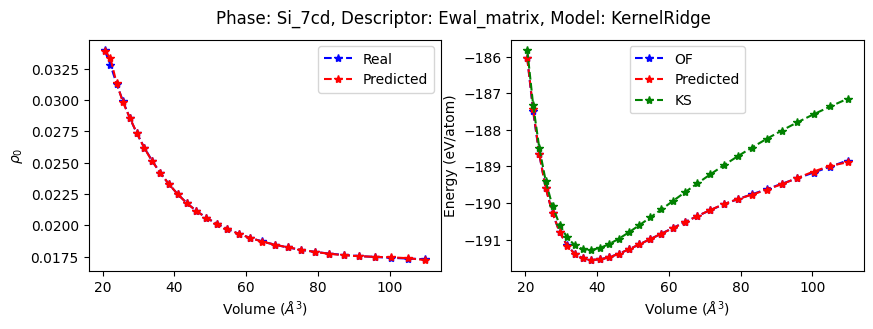

In [25]:
if __name__ == '__main__':
    main()